In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC

# Configs

In [17]:
project_root = "D:/Projects/Summer-2024-ECE-597-Group8"
random_state = 42
test_size = 0.1

In [18]:
df = pd.read_csv(
    os.path.join(project_root, "data", "processed", "features_labels.csv")
)

# Analysis

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28281 entries, 0 to 28280
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Word_Count            28281 non-null  int64
 1   Homoglyphs            28281 non-null  int64
 2   Total_Abnormal_Count  28281 non-null  int64
 3   html_tags             28281 non-null  int64
 4   js_code               28281 non-null  int64
 5   Label                 28281 non-null  int64
dtypes: int64(6)
memory usage: 1.3 MB


In [20]:
df.describe()
df

,Word_Count,Homoglyphs,Total_Abnormal_Count,html_tags,js_code,Label
0,208,0,0,0,0,0
1,38,0,0,0,0,0
2,206,0,1,0,0,0
3,106,0,0,0,0,0
4,19,0,0,0,0,0
...,...,...,...,...,...,...
28276,1721,0,2,1,0,0
28277,52,0,0,0,0,0
28278,71,0,0,6,0,1
28279,60,0,0,0,0,0


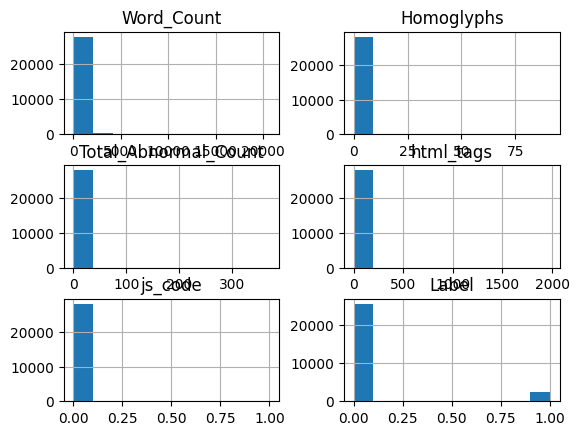

In [21]:
df.hist()
plt.show()

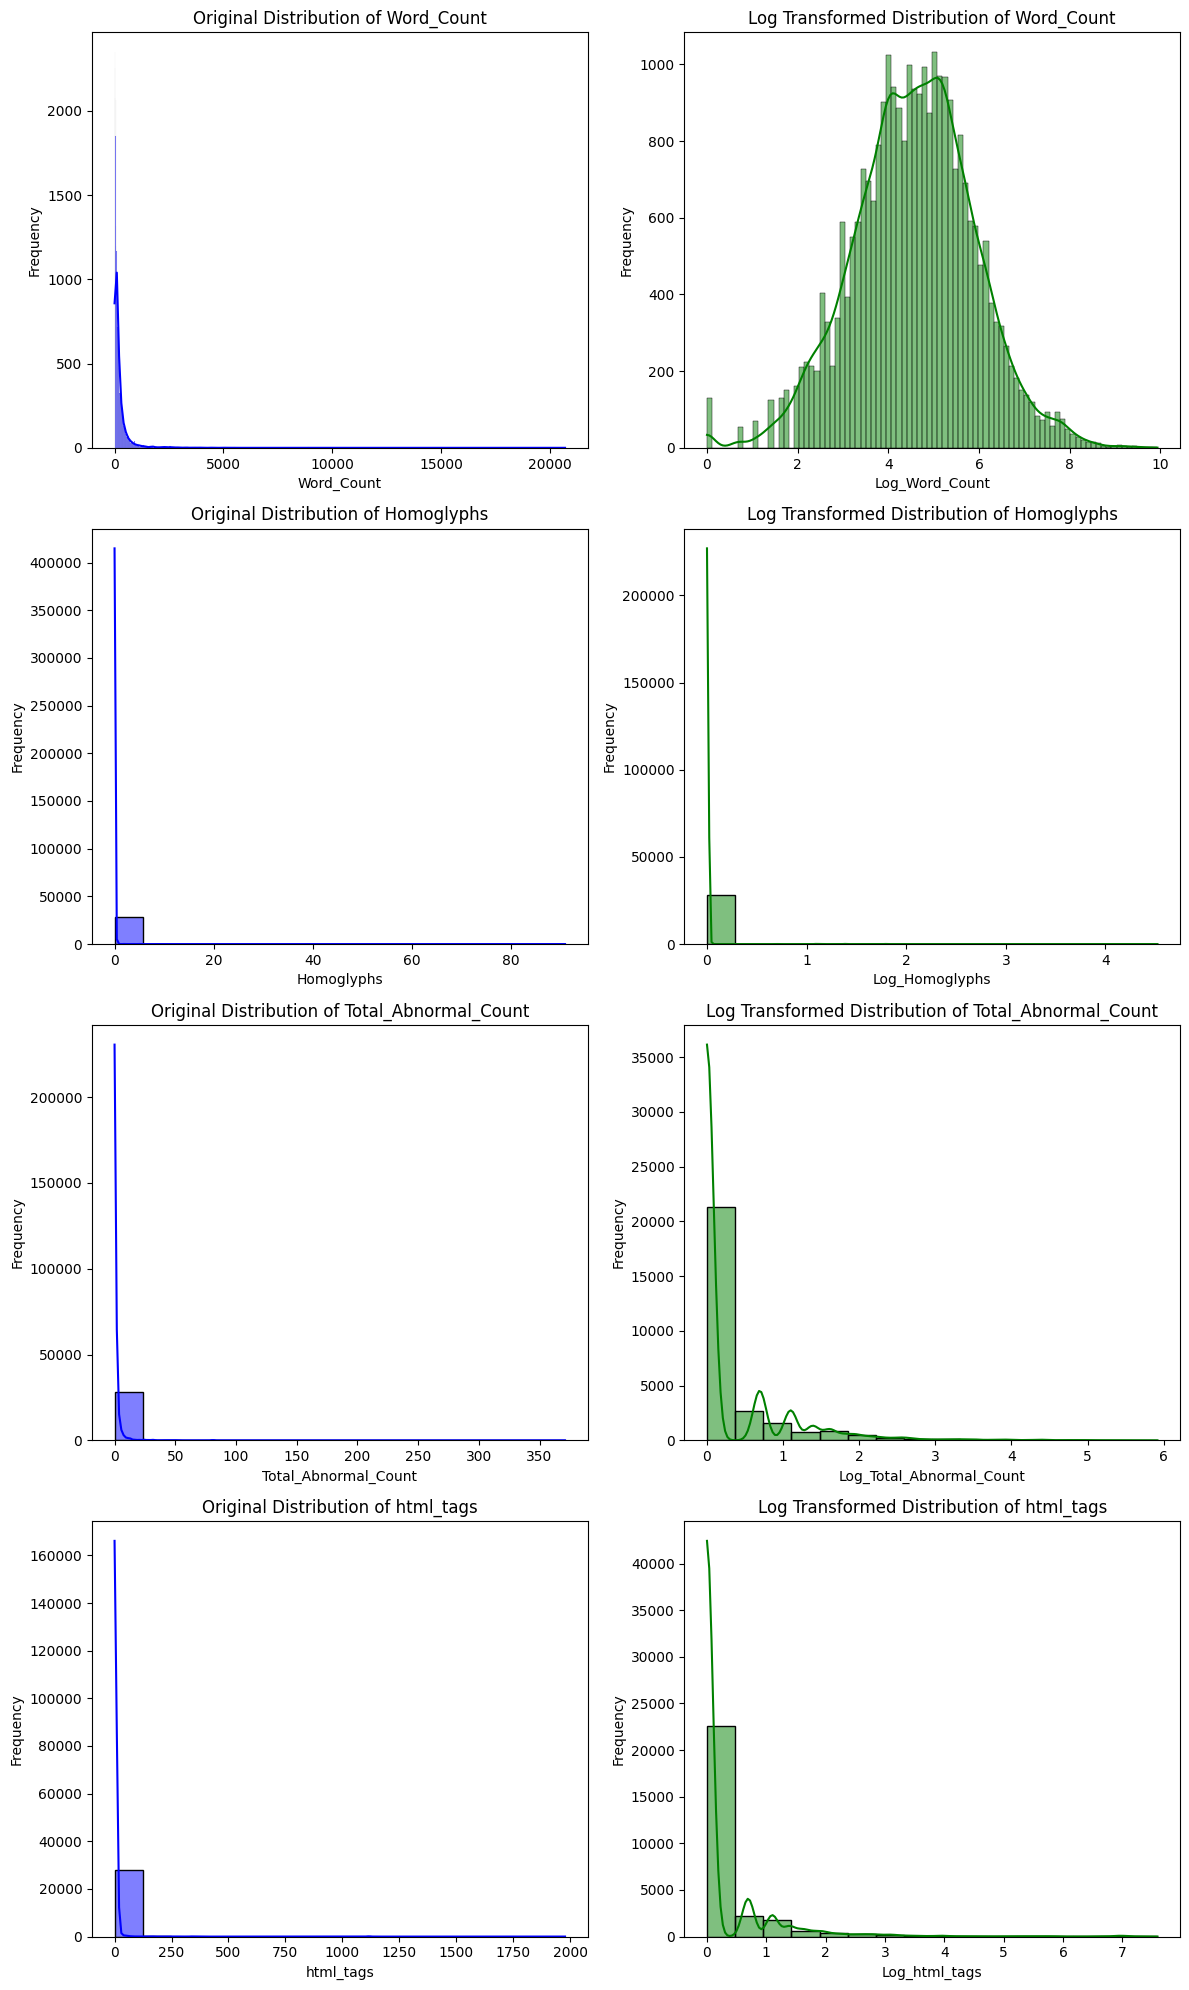

In [22]:
features = ['Word_Count', 'Homoglyphs', 'Total_Abnormal_Count', 'html_tags']

# Setup the plot
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 5 * len(features)))

# Loop through each feature
for i, feature in enumerate(features):
    # Apply log transformation
    log_transformed = np.log1p(df[feature])
    
    # Plot original distribution
    sns.histplot(df[feature], kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'Original Distribution of {feature}')
    axes[i, 0].set_xlabel(f'{feature}')
    axes[i, 0].set_ylabel('Frequency')
    
    # Plot log transformed distribution
    sns.histplot(log_transformed, kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'Log Transformed Distribution of {feature}')
    axes[i, 1].set_xlabel(f'Log_{feature}')
    axes[i, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

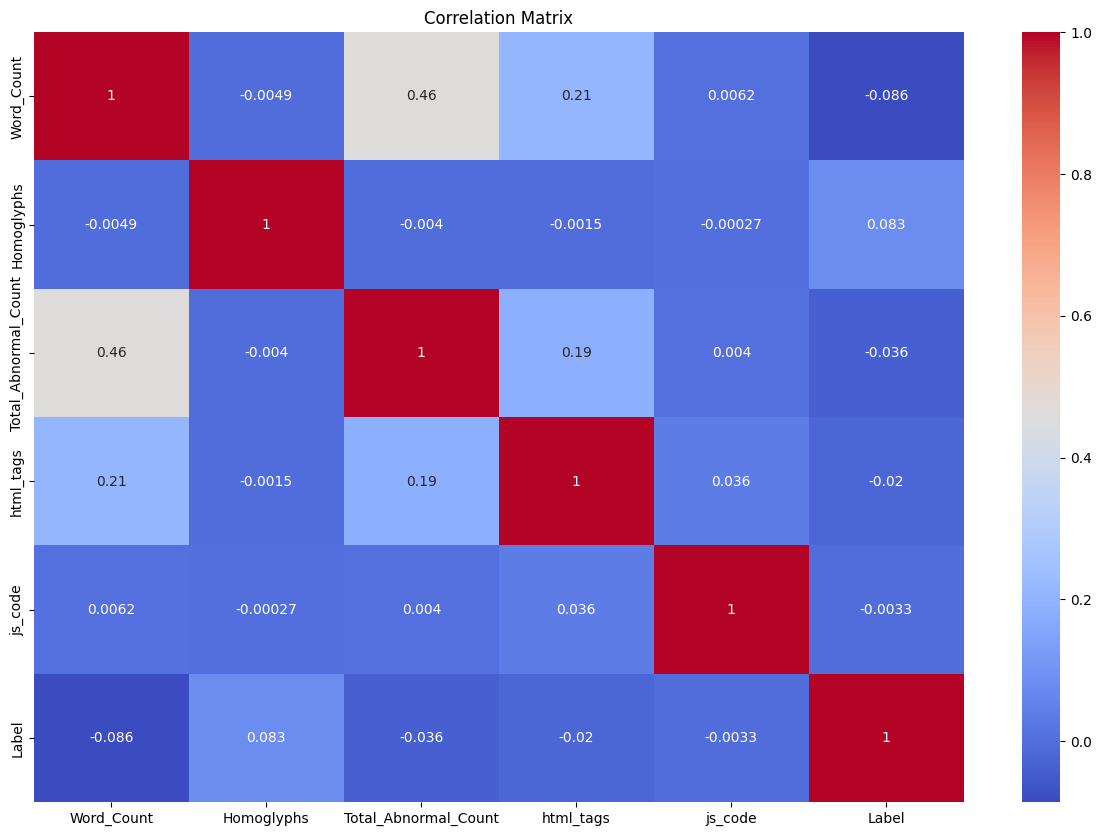

In [23]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Experiments

In [24]:
def evaluate_model(model, X, y, cv=3, method='decision_function', test=False):
    """
    Evaluates the performance of a binary classifier using cross-validation.

    Args:
    model (estimator): The machine learning model to evaluate.
    X (DataFrame or array-like): Feature data used for training the model.
    y (array-like): True labels.
    cv (int): Number of cross-validation folds.

    Returns:
    None
    """
    if test:
        # Predictions
        y_pred = model.predict(X)
        y_scores = model.predict_proba(X)[:, 1]  # Probabilities for the positive class
    else:
        # Get decision function scores via cross-validation
        y_scores = cross_val_predict(model, X, y, cv=cv, method=method)
        # Convert decision scores to binary predictions using 0 as a threshold
        y_pred = (y_scores > 0).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y, y_pred))

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Calculate and print accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate ROC-AUC and Precision-Recall
    roc_auc = roc_auc_score(y, y_scores)
    average_precision = average_precision_score(y, y_scores)

    # Print ROC-AUC and Average Precision-Recall scores
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

In [25]:
X = df.drop(columns=["Label"])
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [26]:
def bool_to_int(x):
    return x.astype(int)


def log_transform(x):
    return np.log1p(x)


log_transform_pipeline = make_pipeline(FunctionTransformer(log_transform))
log_transform_pipeline_MinMax = make_pipeline(
    FunctionTransformer(log_transform), MinMaxScaler()
)
log_transform_pipeline_StandardScaler = make_pipeline(
    FunctionTransformer(log_transform), StandardScaler()
)
log_transform_pipeline_RobustScaler = make_pipeline(
    FunctionTransformer(log_transform), RobustScaler()
)

features_preprocessor = ColumnTransformer(
    transformers=[
        (
            "log_transform",
            log_transform_pipeline_RobustScaler,
            [
                "Word_Count",
                "Homoglyphs",
                "Total_Abnormal_Count",
                "html_tags",
                "js_code",
            ],
        ),
    ],
    remainder="passthrough",
)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     23122
           1       0.67      0.31      0.42      2330

    accuracy                           0.92     25452
   macro avg       0.80      0.65      0.69     25452
weighted avg       0.91      0.92      0.91     25452

Confusion Matrix:
[[22762   360]
 [ 1609   721]]
Accuracy: 0.92
ROC-AUC Score: 0.65
Average Precision-Recall Score: 0.27


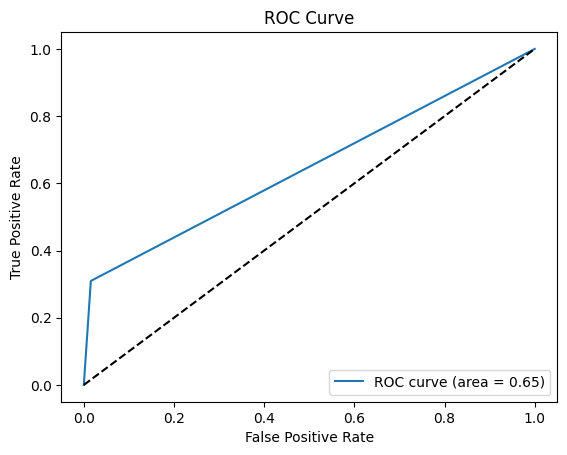

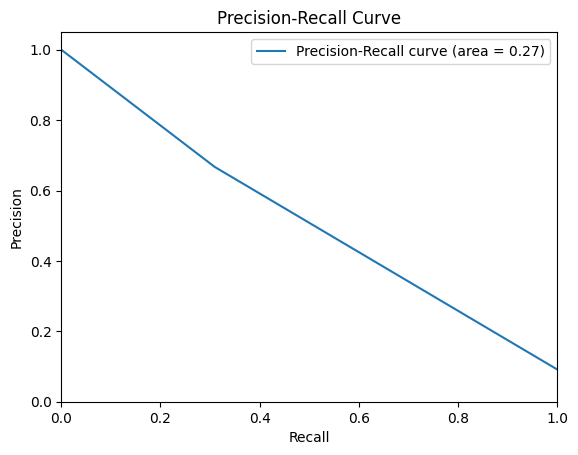

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2588
           1       0.71      0.34      0.46       241

    accuracy                           0.93      2829
   macro avg       0.83      0.66      0.71      2829
weighted avg       0.92      0.93      0.92      2829

Confusion Matrix:
[[2555   33]
 [ 159   82]]
Accuracy: 0.93
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.48


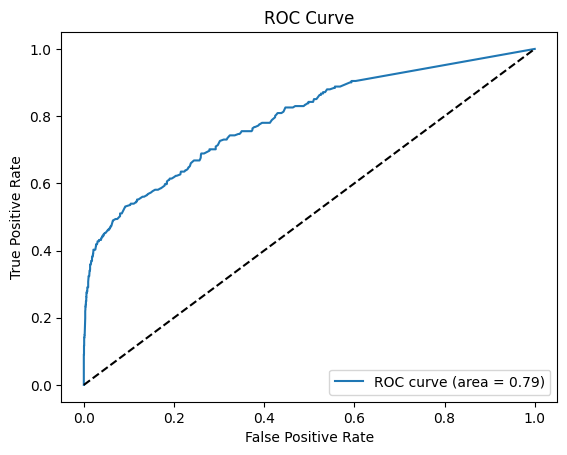

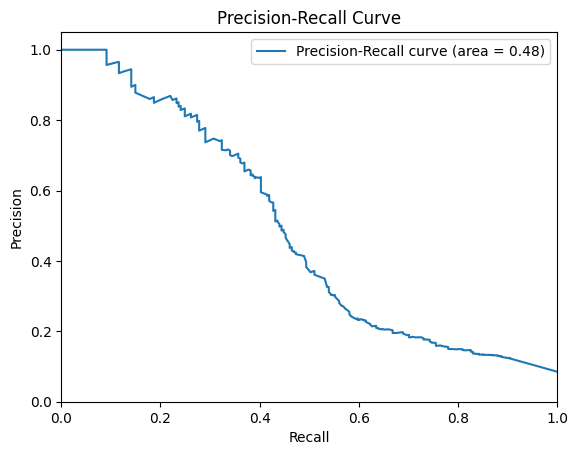

In [29]:
model_rf = make_pipeline(
    features_preprocessor,
    # PCA(n_components=0.95),
    RandomForestClassifier(
        n_estimators=100, random_state=random_state
    ),
)

model_rf.fit(X_train, y_train)
evaluate_model(model_rf, X_train, y_train, method='predict')
evaluate_model(model_rf, X_test, y_test, method='predict', test=True)